# Data Augmentation for Computer Vision
*Author: Charles (Charlie) Rice for Break Through Tech*

---



Neural networks are probably the greatest fundamental advance in machine learning since Allan Turing proposed his famous test of computer intelligence. They are capable of learning deep, hidden patterns in data and making powerful, accurate predictions from them.

Even so, there is still no free lunch in machine learning, and neural networks are not perfect. They are prone to overfitting without serious attention to regularization, and they require massive amounts of computing power and data to learn effectively - data we don't always have in the requisite volume.

You may recall the concept of the bootstrap in statistical sampling - randomly re-selecting observations from a minority class in order to expand that class artificially. We can do something similar with image data [using Pillow, the 'friendly fork' of the Python Imaging Library](https://pillow.readthedocs.io/en/stable/index.html).

There's a lot that can be done with images using PIL and we're barely going to scratch the surface. Keep in mind, though, that a lot of what is going on in this notebook is a judgement call. You, as a data scientist and machine learning engineer, need to be able to explain what you're doing and why you think it's a good idea.

# Learning Objectives

By the end of this demonstration, you will be able to:

1. Manipulate files using the Python `os` module.
2. Perform basic image augmentation (rotation, flipping, and brightness adjustment) using the Python Imaging Library, Pillow, or `PIL`.
3. Downsize images to a required format while maintaining aspect ratio.

In [ ]:
# os is the operating systems library for python
import os

# random will enable the randomness functions
import random
import numpy as np

# tqdm creates a smart progress meter; useful for long processing jobs
from tqdm import tqdm

# Use Python Image Libary (PIL) to display and manipulate images
from PIL import Image, ImageEnhance, ImageFilter

# Data
We're going to be working with the [Cats and Dogs data](https://www.google.com/url?q=https%3A%2F%2Fwww.microsoft.com%2Fen-us%2Fdownload%2Fdetails.aspx%3Fid%3D54765) from Microsoft. This is already a smaller sample of a much larger set, but we're going to sample it again to demonstrate data augmentation.

You'll notice in the code cells below that the `!` works here in Google Colab just as it does in your local Jupyter notebook. It enables us to access the command prompt and the file structure around the notebook we're currently using.

In [ ]:
## Uncomment the line below and run it.
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  82.6M      0  0:00:09  0:00:09 --:--:-- 81.5M


In [ ]:
## Uncomment the lines below and run them
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


If you look at the files tab to the left, we've now got the PetImages directory.

In [ ]:
os.listdir()

['.config',
 'PetImages',
 'CDLA-Permissive-2.0.pdf',
 'readme[1].txt',
 'kagglecatsanddogs_5340.zip',
 'sample_data']

Which contains two directories

In [ ]:
os.listdir('./PetImages')

['Dog', 'Cat']

In [ ]:
print("Size of 'Dog':", len(os.listdir('PetImages/Dog')))
print("Size of 'Cat':", len(os.listdir('PetImages/Cat')))

Size of 'Dog': 12501
Size of 'Cat': 12501


This is clearly a lot of data, enough to build an effective classifier on. So in order to demonstrate effective augmentation techniques, we're going to sample this data down to just 100 images in each class. We're drawing a uniform sample - every image has an equal chance of being selected. Since we only have two classes, and they are equally sized at that, this is not a controversial decision.

In [ ]:
def sample_files_from_directories(base_dir, sample_size_per_class):
    """
    Draws a uniform sample of filenames from directories, where each directory represents a class.

    Parameters:
        base_dir (str): The path to the base directory containing subdirectories.
        sample_size_per_class (int): The number of filenames to sample from each class directory.

    Returns:
        dict: A dictionary with class labels (directory names) as keys and lists of sampled filenames as values.
    """
    # Dictionary to store sampled filenames for each class
    sampled_files = {}

    # Iterate through each subdirectory ('class_dir') in the base directory ('base_dir')
    for class_dir in tqdm(os.listdir(base_dir), desc="Processing classes"):
        class_path = os.path.join(base_dir, class_dir)

        # Get all filenames in the current class directory
        filenames = os.listdir(class_path)

        # Check if there are enough files to sample from
        if len(filenames) < sample_size_per_class:
            print(f"Warning: Not enough files in class '{class_dir}' to sample {sample_size_per_class}. Using all available files.")
            sampled_files[class_dir] = filenames
        else:
            # Randomly sample files from the current class directory
            sampled_files[class_dir] = random.sample(filenames, sample_size_per_class)

    return sampled_files


In [ ]:
# Execute the sample_files function and save it to a variable called 'samples'
samples = sample_files_from_directories("./PetImages", 100)

Processing classes: 100%|██████████| 2/2 [00:00<00:00, 96.01it/s]


And we should double check that the function did what it was supposed to:

In [ ]:
len(samples['Dog'])

100

In [ ]:
# If we use the set() function on the `Dog` samples we get all the unique filenames
len(set(samples['Dog']))

100

In [ ]:
len(samples['Cat'])

100

In [ ]:
# And again, using set() to get the unique values in Cat
len(set(samples['Cat']))

100

Just to maintain some clarity in our file structure, we're going to make copies of the files that are sampled into a new sample directory inside `PetImages`.

In [ ]:
def copy_sampled_files(base_dir, sampled_files):
    """
    Copies sampled files into new directories named 'sample_{class_name}' inside the base directory.

    Parameters:
        base_dir (str): The path to the base directory containing class directories.
        sampled_files (dict): A dictionary with class labels as keys and lists of sampled filenames as values.
    """
    for class_label, files in tqdm(sampled_files.items(), desc="Copying sampled files"):
        # Create the target directory for the sampled files
        sample_dir = os.path.join(base_dir, f"sample_{class_label}")
        os.makedirs(sample_dir, exist_ok=True)

        # Copy each sampled file to the target directory
        for file_name in files:
            # Create a source path and a destination path using the os.path.join function
            # This function combines its parameters to make a legitimate filepath
            src_path = os.path.join(base_dir, class_label, file_name)
            dest_path = os.path.join(sample_dir, file_name)

            try: # Using a try-except loop to copy files from one directory to another
                if os.path.isfile(src_path): # check that the src_path variable is valid
                    with open(src_path, 'rb') as src_file: # reading the source file as a binary ('rb')
                        with open(dest_path, 'wb') as dest_file: # write the source file as a binary ('wb')
                            dest_file.write(src_file.read())
            except Exception as e:
                print(f"Error copying file {file_name} from class {class_label}: {e}")

And execute the copy function to create copies and move them to a new pair of directories:

In [ ]:
copy_sampled_files("PetImages", samples)

Copying sampled files: 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]


And we should check that the function did its job:

In [ ]:
os.listdir('PetImages')

['Dog', 'Cat', 'sample_Dog', 'sample_Cat']

In [ ]:
len(set(os.listdir("PetImages/sample_Dog")))

100

In [ ]:
len(set(os.listdir("PetImages/sample_Cat")))

100

The functions worked! We now have 100 images each of the Cat and Dog directories. Let's double check that the images are, in fact, images.

In [ ]:
spot_cat = os.listdir("PetImages/sample_Cat")[0]

Although the `os` library looks a bit scary, `listdir` returns a list just like any other Python list. We can access specific elements with indexing, and save it to a variable.

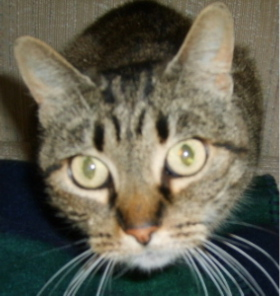

In [ ]:
filepath = "PetImages/sample_Cat/" + spot_cat

with Image.open(filepath) as img:
  display(img)

In [ ]:
spot_dog = os.listdir('PetImages/sample_Dog/')[0]

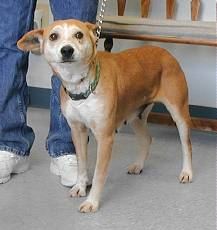

In [ ]:
filepath = "PetImages/sample_Dog/" + spot_dog

with Image.open(filepath) as img:
  display(img)

# Image Augmentation

Now that we have some images to work with, let's talk a bit about image augmentation.

There are two main reasons we do image augmentation. The first, as demonstrated in the image processing notebook, is to help reduce the overfitting that neural networks are prone to. This is an *augmentation layer* inside of the neural network architecture that randomly applies an arbitrary number of transformations to an image during learning. This **does not** expand the size of the dataset.

The second use case is about actually expanding the size of a dataset. It involves flipping, rotating, and otherwise lightly distorting images in order to create a new-ish image for the neural network to learn from. Note the key word there is *lightly*. The image should still be human-recognizable as an example of its class. What we are doing is akin to the bootstrap for tabular data - creating 'new' samples out of old samples.

Let's take a look at some basic transformations, transformations we should be comfortable doing, and then some transformations that are more radical, which we should think carefully about before applying.

## Basic Transformations
There are some very basic transformations that we can do using the Python Image Library. Let's take a look at three that don't have a huge impact on the image itself.

### Rotation
Using PIL we can rotate an image through a full circle of 360 degrees.

Here's our original image:


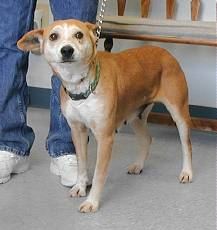

Here's the same image rotated counterclockwise 45 degrees


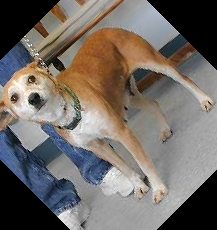

In [ ]:
print("Here's our original image:")
display(img)
# Rotate the image
rotated = img.rotate(45)
print("Here's the same image rotated counterclockwise 45 degrees")
display(rotated)


### Flipping
And we can flip the image around its vertical or horizontal axis.

Here's the original image: 


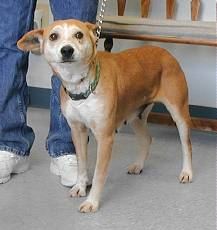


 And here's the same image flipped left to right.


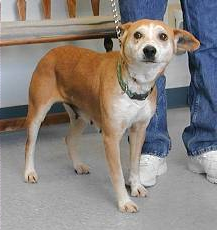


 And top to bottom


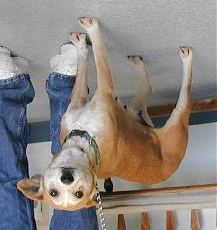

In [ ]:
print("Here's the original image: ")
display(img)
# Flip the image horizontally
flipped = img.transpose(Image.FLIP_LEFT_RIGHT)
print("\n And here's the same image flipped left to right.")
display(flipped)
upside = img.transpose(Image.FLIP_TOP_BOTTOM)
print("\n And top to bottom")
display(upside)



### Brightness
We can also adjust the brightness of the image.

Here's the original image.


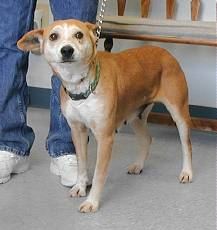


 Here's the image with brightness increased by 50%


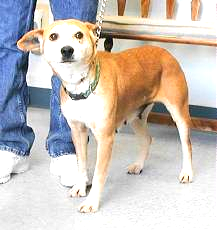

In [ ]:
print("Here's the original image.")
display(img)

# Adjust the brightness
enhancer = ImageEnhance.Brightness(img)
bright = enhancer.enhance(1.5)  # Increase brightness by 50%
print("\n Here's the image with brightness increased by 50%")
display(bright)

Those three (rotation, flipping, and brightness) are all fairly vanilla transformations of the image. The animal is clearly still the animal of its class, just rotated about an axis or washed out a little bit.

But PIL enables us to do some more radical transformations that should be used with care.

### Guassian Blur
We can blur the image using [a Gaussian function](https://en.wikipedia.org/wiki/Gaussian_blur).

The image below, with a Gaussian blur of radius 3, is fine.

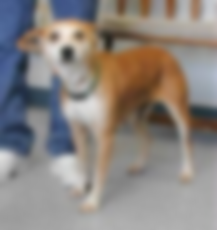

In [ ]:
light_blurred = img.filter(ImageFilter.GaussianBlur(radius=3))
display(light_blurred)

The image below, with a Gaussian blur of radius 10, is not. Is that a dog? Could be a cat. Maybe a rodent of some kind, or a very small horse.

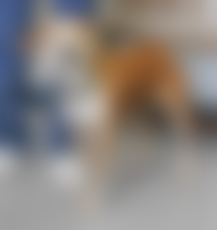

In [ ]:
heavy_blurred = img.filter(ImageFilter.GaussianBlur(radius=10))
display(heavy_blurred)

### Color Enhance
We can also alter the color balance of an image, exaggerating (>1.0) or muting colors (<1.0) as we like.

In [ ]:
# ImageEnhance.color adjusts the color balance of an image. 0.0 is grayscale/black-and-white
# 1.0 is the original image
color_enhancer = ImageEnhance.Color(img) # Creates a matrix for future enhancement
extreme_color = color_enhancer.enhance(4.0) # The actual color enhancements

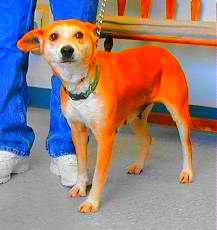

In [ ]:
display(extreme_color)

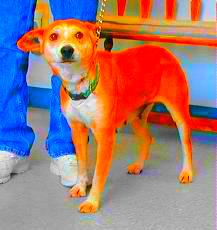

In [ ]:
extremer_color = color_enhancer.enhance(8.0)
display(extremer_color)

### Noisy Images
And we can add noise into an image. A little noise is fine, adjusted here using the `np.random.normal` function. The second parameter there (here set to 25) controls the scale (aka standard deviaion) of the normal distribution and thus the amount of noise added to the image.

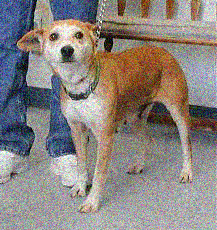

In [ ]:
image_array = np.array(img)
noise = np.random.normal(0, 25, image_array.shape)  # Generate random noise
noisy_image = np.clip(image_array + noise, 0, 255).astype('uint8')  # Add noise and clip values
noisy_image = Image.fromarray(noisy_image)
display(noisy_image)

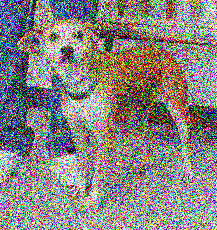

In [ ]:
# Up the sigma to 100 and the image gets much harder to see
image_array = np.array(img)
noise = np.random.normal(0, 100, image_array.shape)  # Generate random noise
noisy_image = np.clip(image_array + noise, 0, 255).astype('uint8')  # Add noise and clip values
noisy_image = Image.fromarray(noisy_image)
display(noisy_image)

### Downsizing
There's one last transformation that's useful for things beyond data augmentation, which is thumbnailing. This process preserves image quality and aspect ratio while reducing the size of the image. **NOTE** Unlike the other methods, `thumbnail` operates in place, so it does not make a copy of the image but acts on the image itself. That's why, in the example below, `thumb` is a copy of `img.`

Here's the original image: 


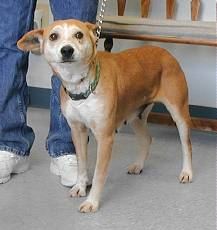


Here's the thumbnail version at 128 pixels by 128 pixels:


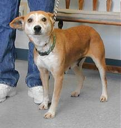

In [ ]:
max_size = (128,128)

print("Here's the original image: ")
display(img)

print(f"\nHere's the thumbnail version at {max_size[0]} pixels by {max_size[1]} pixels:")
thumb = img.copy()
thumb.thumbnail(max_size)
display(thumb)


There's more that can be done, and you are encouraged to play around with the PIL to test out its power. But so far, all we have done is show the transformations. Since we want to expand our dataset, we also need to save these images.

We'll save one image separately, and then wrap the whole process of augmentation up in a loop.

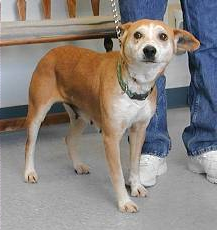

In [ ]:
display(flipped)

In general, when working with os and input/output functions like it, it's a good idea to be explicit about the source and destination directories of the files you're working with. Note that we're basically keeping the augmented images in the same directory in order to keep in conformity with the Keras workflow.

In [ ]:
src_dir = "./PetImages/sample_Dog/" # source of the images to be transformed
dest_dir = "PetImages/sample_Dog"

We have the original filename that we've been working with:

In [ ]:
filepath

'PetImages/sample_Dog/7368.jpg'

In [ ]:

file_root = os.path.split(filepath)[0]

In [ ]:
# This gets us just the name of the file without the .jpg extension
# It's useful for renaming the file with an indicator that it's augmented.
filename = os.path.split(filepath)[1][:-4]

Let's do one manipulation and save a new image.

Original Image: 


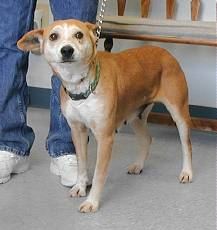

Rotated 45 degrees


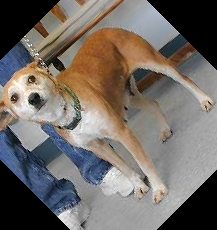

In [ ]:
# The `with` is a context manager that will close the file when we're done with it
with Image.open(filepath) as img:
  print("Original Image: ")
  display(img)

  rotated = img.rotate(45)
  print("Rotated 45 degrees")
  display(rotated)

  rotated.save(os.path.join(dest_dir, f"{filename}r.jpg")) # 'r' for rotated

In [ ]:
## Because the sampling is random, the images selected for this demo change.
## This cell simply breaks up the file path name so that it can be reconstructed
## in the cell below
root = os.path.split(filepath)[0] + "/"
fname = os.path.split(filepath)[1][:-4]
exten = ".jpg"

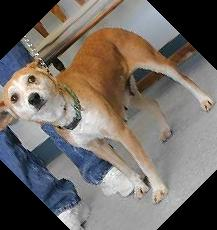

In [ ]:
# And check that it saved correctly
with Image.open(root + fname + "r" + exten) as img:
  display(img)

Let's put it all together in one loop and augment the sample_Dog directory.

In [ ]:
## Let's do a simple 45-degree rotation and save the image
## Remember that src_dir is just the sample_Dog directory
## NOTE: Executing this cell multiple times will increase the nujmber of images
## By about 100 each time
for file in tqdm(os.listdir(src_dir)):
  filename = file[:-4]

  with Image.open(src_dir + file) as img:
    rotated = img.rotate(45)
    try:
      rotated.save(os.path.join(src_dir, f"{filename}r.jpg")) # 'r' for rotated
    except:
      # Not every image is in the correct formate for us to be able to manipulate
      print(f"Failed to save image {filename}")

100%|██████████| 101/101 [00:00<00:00, 320.39it/s]


In [ ]:
# Let's check the work
len(os.listdir("PetImages/sample_Dog"))

201

In [ ]:
spot_check = []
for file in os.listdir("PetImages/sample_Dog"):
  if 'r' in file.lower():
    spot_check.append(file)

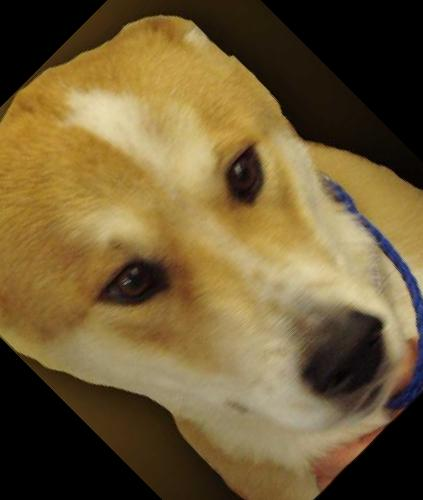

In [ ]:
# And spot check one image
with Image.open("PetImages/sample_Dog/"+ spot_check[0]) as img:
  display(img)

In [ ]:
# Check against its original image
original = spot_check[0].replace("r","")

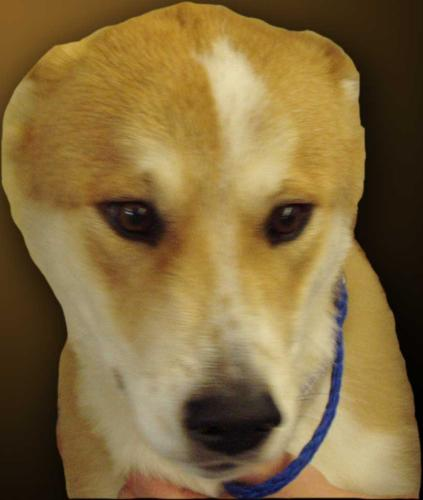

In [ ]:
with Image.open("/content/PetImages/sample_Dog/"+original) as img:
  display(img)

Everything looks copacetic!

This code is written to be fairly extensible, and you are encouraged to play around with the image manipulation possibilities that come along with PIL. Try introducing randomness into the manipulations you're using or add in multiple manipulations for some images, while ignoring others. There are, finally, a few things to think about when doing data augmentation with images:


1.   The image still needs to be human-recognizable. Too much noise in the image through blurring, noise, rotation, is likely to make it harder for the neural network to learn.
2.   Augmentation needs to be guided by the learning objective. A learning problem focused on a medical problem has higher stakes than recognizing cats and dogs; caution and judiciousness in the augmentation needs to be used.
3. Make sure that you preserve any labeling that comes with the data. If the labels are stored in a CSV, rather than images in a directory, you'll have more work to do to keep the labels synced with the images.
4. Augmenting data *CAN* increase the bias in a dataset, but it can also improve the balance in favor of sensitive groups. If your images, for example, contain people of different skin tones you probably already have an imbalanced dataset on that feature. You could correct this by increasing the number of less-common skin tone images.
5. Record, Record, Record. Make sure you make a note of every change you make to the data and explain your rationale. Even if you are doubling your datasaet with 45 degree rotations, you need to make a note of it and explain why you're doing it.





# Conclusion
In this notebook, we have discussed data augmentation specifically within the context of image data. We have shown how to use some of the `os` library for file management and the `PIL` library for image manipulation. And we have used both those tools to double the dataset we had.
